<a href="https://colab.research.google.com/github/cedricfoucault/scarletbutterfly/blob/master/scarletbutterfly_decoding_steinmetz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

In [15]:
#@title Data retrieval
import os, requests
import matplotlib.pyplot as plt
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [16]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

n_sessions = len(alldat)
print("n_sessions", n_sessions)

n_sessions 39


In [17]:
print(alldat[0].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [18]:
#@title Filter Trial Data
import copy
filtered_data = copy.deepcopy(alldat)

bin_size = alldat[0]['bin_size']
stim_onset = alldat[0]['stim_onset']
for i in range(len(alldat)):
  assert bin_size == alldat[i]['bin_size'], "inconsistent bin size"
  assert stim_onset == alldat[i]['stim_onset'], "inconsistent stim onset"

# Filter only the keys we are going to use
# used_keys = ['spks', 'pupil', 'lfp', 'response', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'mouse_name']
used_keys = ['spks', 'pupil', 'response', 'contrast_right', 'contrast_left', 'brain_area', 'mouse_name']
for i_session in range(n_sessions):
  filtered_data[i_session] = { key: filtered_data[i_session][key] for key in used_keys }


# # Eliminate trials where contrast is > 0 and equal on both sides
array_keys = ['spks', 'pupil','lfp', 'response', 'contrast_right', 'contrast_left']



for i_session in range(n_sessions):
  session_data = filtered_data[i_session]
  equal_contrast = session_data['contrast_right'] == session_data['contrast_left']
  positive_contrast_right = session_data['contrast_right'] > 0
  should_filter = equal_contrast & positive_contrast_right

  session_data['spks'] = session_data['spks'][:,~should_filter,:]
  session_data['pupil'] = session_data['pupil'][:,~should_filter,:]
  # session_data['lfp'] = session_data['lfp'][:,~should_filter,:]

  session_data['response'] = session_data['response'][~should_filter]
  session_data['contrast_right'] = session_data['contrast_right'][~should_filter]
  session_data['contrast_left'] = session_data['contrast_left'][~should_filter]

  # for key, value in session_data.items():
  #   if key in array_keys:
  #     print("key", key)
  #     print("array.shape", value.shape)
  # new_session_data = { key: array[~should_filter] for key, array in session_data.items() }
  # filtered_data[i_session] = new_session_data
  # print("session:", i_session)
  # print("original data, contrast_right:", session_data['contrast_right'])
  # print("filtered data, contrast_right:", new_session_data['contrast_right'])






In [19]:
#Extracting brain areas:
brain_areas = set()

for i in range(n_sessions):
  brain_areas.update(filtered_data[i]['brain_area'])


#Let's focus on subcortical brain areas as they appear to experience a spike 
#Basal ganglia, midbrain
basal_ganglia = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]
midbrain = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"]

count_dict = {area:0 for area in brain_areas}

for i in range(n_sessions):
  for area in set(filtered_data[i]['brain_area']):
      count_dict[area] += 1

print(count_dict)
areas = list(count_dict.keys())
count_sessions_per_areas = np.array(list(count_dict.values()))
sorted_indices = np.argsort(count_sessions_per_areas)
areas = [ areas[i] for i in sorted_indices ]
count_sessions_per_areas = count_sessions_per_areas[sorted_indices]
y_bars = np.arange(len(areas))
# fig = plt.figure(figsize=(5., len(y_bars) / 4))
# ax = fig.gca()
# ax.barh(y_bars, count_sessions_per_areas)
# ax.set_yticks(y_bars)
# ax.set_yticklabels(areas)
# plt.show()

{'VAL': 1, 'MOs': 18, 'MG': 2, 'VISp': 12, 'GPe': 3, 'VISl': 3, 'PL': 10, 'VPM': 4, 'AUD': 1, 'TH': 8, 'DP': 1, 'RT': 2, 'MRN': 11, 'CA2': 1, 'POST': 4, 'IC': 1, 'SCs': 4, 'LH': 2, 'LS': 3, 'CP': 5, 'VPL': 4, 'SPF': 2, 'VISrl': 2, 'LSc': 1, 'SI': 1, 'POL': 3, 'root': 34, 'ILA': 3, 'APN': 2, 'VISpm': 4, 'ZI': 4, 'OT': 1, 'SNr': 4, 'CA1': 21, 'SSp': 5, 'OLF': 3, 'SCig': 4, 'RN': 1, 'COA': 1, 'PT': 1, 'PAG': 3, 'CA': 1, 'EPd': 1, 'CA3': 10, 'SSs': 1, 'TT': 4, 'LSr': 4, 'MB': 6, 'MD': 3, 'VISa': 5, 'RSP': 9, 'CL': 1, 'PO': 5, 'NB': 1, 'ACB': 3, 'SUB': 9, 'LD': 6, 'SCsg': 6, 'LGd': 10, 'ORB': 5, 'SCm': 7, 'EP': 1, 'PIR': 1, 'BMA': 1, 'DG': 16, 'BLA': 2, 'MOp': 3, 'VISam': 11, 'ACA': 11, 'MEA': 1, 'ORBm': 1, 'MS': 1, 'LP': 11}


In [20]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [21]:
# Histograms of num. of neurons by brain area for each session
# for i in range(n_sessions):
#   plt.hist(filtered_data[i]['brain_area'])
#   plt.show()

In [22]:
# Calculate number of trials per session
n_trials_session = np.zeros(n_sessions)
for i in range(n_sessions):
  n_trials_session[i] = len(filtered_data[i]['response'])

240.46153846153845


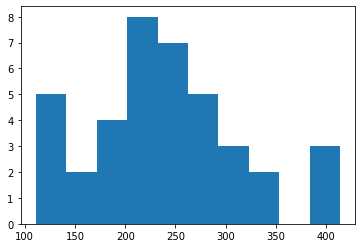

In [23]:
#@title Histogram of number of trials throughout the sessions
# Histogram of number of trials throughout the sessions
plt.hist(n_trials_session)
print(n_trials_session.mean())

In [24]:
# Select one session
i_session_max_trials = np.argmax(n_trials_session)
print(i_session_max_trials, n_trials_session[i_session_max_trials])

9 414.0


We'll focus on the session i_session_max_trials, which has the most trials and analyze the activity in the brain areas recorded during this session to try to predict the mouse's response during the trials.

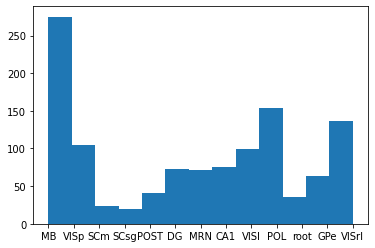

275

In [25]:
#@title Histogram of num of neurons per brain area for the selected session 
plt.hist(filtered_data[i_session_max_trials]['brain_area'],bins=13)
plt.show()
np.count_nonzero(filtered_data[i_session_max_trials]['brain_area']=='MB')

## Helper functions for retrieving data

In [26]:
def get_outcomes_correct_with_session(session_data):
  response = session_data['response'] # right - nogo - left (-1, 0, 1)
  vis_right = session_data['contrast_right'] # 0 - low - high
  vis_left = session_data['contrast_left'] # 0 - low - high
  correct_response = np.sign(vis_left-vis_right) 
  is_correct = response == correct_response
  outcomes_correct = is_correct.astype(int)
  return outcomes_correct

In [27]:
#@title Retrieve correct (1) or incorrect (0) outcome
i_focus = i_session_max_trials
outcomes_correct = get_outcomes_correct_with_session(filtered_data[i_focus])
print(outcomes_correct.mean())

0.6376811594202898


In [28]:
def get_neurons_spikes_with_session_area_window(session_data, brain_area, window):
  is_brain_area = session_data['brain_area'] == brain_area
  return session_data['spks'][is_brain_area, :, window]

In [30]:
#filtered_data_focus is not define
# focus_brain_area='MB'
# spikes_focus = get_neurons_spikes_with_session_area_window(filtered_data_focus, focus_brain_area, slice(0, 250, 1))


NameError: ignored

## Helper functions for decoding

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
def compute_single_neuron_decoding_accuracies(spikes_per_neuron, outcomes, penalty='none'):
  n_neurons = spikes_per_neuron.shape[0]
  n_trials = spikes_per_neuron.shape[1]
  # average over time
  spikes_per_neuron_time_avg = spikes_per_neuron.mean(axis=2)
  decoding_accuracies = np.empty(n_neurons)
  decoding_accuracies_chance = np.empty(n_neurons)
  for i_neuron in range(n_neurons):
    X = spikes_per_neuron_time_avg[i_neuron, :][:, None]
    decoding_accuracies[i_neuron] = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, cv=8, n_jobs=-1).mean()
    # shuffle trials to get chance level
    X = X.copy()
    np.random.shuffle(X)
    decoding_accuracies_chance[i_neuron] = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, cv=8, n_jobs=-1).mean() # k=8 crossvalidation
  return decoding_accuracies, decoding_accuracies_chance

In [40]:
def compute_all_neuron_decoding_accuracies(spikes_per_neuron, outcomes, penalty='l2'):
  n_neurons = spikes_per_neuron.shape[0]
  n_trials = spikes_per_neuron.shape[1]
  # average over time
  spikes_all_neuron_time_avg = spikes_per_neuron.mean(axis=2)
  decoding_accuracies = 0
  decoding_accuracies_chance = 0
  X = spikes_all_neuron_time_avg.T
  decoding_accuracies = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, cv=8, n_jobs=-1).mean()
  # shuffle trials to get chance level
  X = X.copy()
  np.random.shuffle(X)
  decoding_accuracies_chance = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, cv=8, n_jobs=-1).mean() # k=8 crossvalidation
  return decoding_accuracies, decoding_accuracies_chance

## Decode from each individual neuron on each possible brain area and sessions

Ideas to do next:
- try with all the neurons (keeping time average). try L1, L2 regularization, or elasticnet.
-- feedback period
-- prestimulus period
- try with kernel (e.g. polynomial degree 2-3, gaussian)
- try with principal component over the neurons (PCA) # decoding from PCA ~= L2 regularization? <ref needed>
- try to not average over time. each time step = 1 feature. 
- try to decode at the feedback period. or after the go cue. time-average and without.

In [ ]:
window = slice(0, 50, 1)
# window = slice(30, 50, 1)
thresh_print = 0.04
for i_session in range(n_sessions):
  print("session", i_session)
  filtered_data_focus = filtered_data[i_session]
  outcomes_correct = get_outcomes_correct_with_session(filtered_data_focus)
  brain_areas = set(filtered_data_focus['brain_area'])
  for brain_area in brain_areas:
    print("decoding on brain_area", brain_area)
    spikes_per_neuron = get_neurons_spikes_with_session_area_window(filtered_data_focus, brain_area, window)
    decoding_accuracies, decoding_accuracies_chance = compute_single_neuron_decoding_accuracies(spikes_per_neuron, outcomes_correct)
    decoding_accuracies_diff = decoding_accuracies - decoding_accuracies_chance
    if np.any(decoding_accuracies_diff > thresh_print):
      print("found!")
      # print("decoding_accuracies", decoding_accuracies)
      # print("decoding_accuracies_chance", decoding_accuracies_chance)
      print("max diff: ", (decoding_accuracies_diff).max())
      plt.figure()
      plt.hist(decoding_accuracies_diff)
      plt.show()

## Decode from all the neurons on each possible brain area and sessions

session 0
decoding on brain_area LS
decoding on brain_area MOs
decoding on brain_area SUB
decoding on brain_area VISp
decoding on brain_area root
decoding on brain_area DG
decoding on brain_area CA3
decoding on brain_area ACA
session 1
decoding on brain_area CA1
decoding on brain_area VISl
decoding on brain_area root
decoding on brain_area VISpm
decoding on brain_area POST
session 2
decoding on brain_area CA1
decoding on brain_area NB
decoding on brain_area SPF
decoding on brain_area MG
decoding on brain_area VISp
decoding on brain_area root
decoding on brain_area DG
decoding on brain_area VISam
decoding on brain_area MRN
decoding on brain_area POST
decoding on brain_area LP
session 3
decoding on brain_area CA1
decoding on brain_area MOs
decoding on brain_area VPL
decoding on brain_area SUB
decoding on brain_area LGd
decoding on brain_area VISp
decoding on brain_area DG
decoding on brain_area TH
decoding on brain_area ACA
decoding on brain_area LSr
decoding on brain_area VISa
session 4

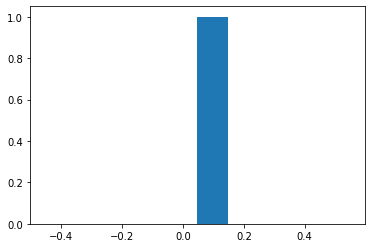

decoding on brain_area MOs
found!
max diff:  0.06034482758620696


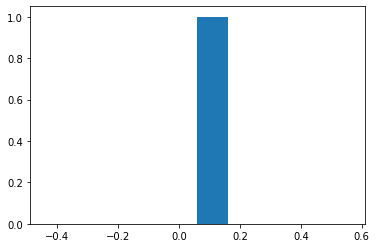

decoding on brain_area LD
decoding on brain_area SUB
decoding on brain_area VISp
decoding on brain_area PL
decoding on brain_area root
decoding on brain_area ILA
decoding on brain_area DG
decoding on brain_area CA3
decoding on brain_area TT
decoding on brain_area LSr
decoding on brain_area VISa
decoding on brain_area LP
session 8
decoding on brain_area CA1
decoding on brain_area VPL
decoding on brain_area LD
decoding on brain_area PL
decoding on brain_area VISl
decoding on brain_area root
decoding on brain_area TT
decoding on brain_area TH
decoding on brain_area CA3
decoding on brain_area VISam
decoding on brain_area ORBm
decoding on brain_area LSr
session 9
decoding on brain_area CA1
decoding on brain_area SCsg
decoding on brain_area SCm
decoding on brain_area VISp
decoding on brain_area VISl
decoding on brain_area POL
decoding on brain_area root
decoding on brain_area GPe
decoding on brain_area VISrl
decoding on brain_area DG
decoding on brain_area POST
decoding on brain_area MRN
dec

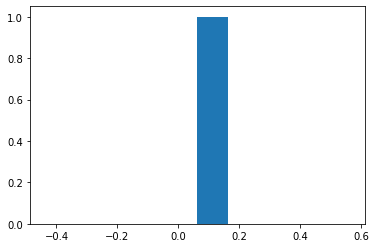

decoding on brain_area VAL
decoding on brain_area LD
found!
max diff:  0.09065934065934067


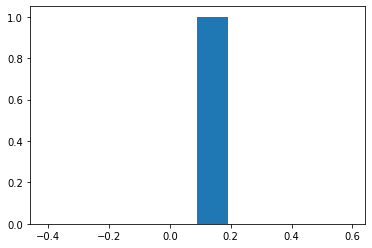

decoding on brain_area root
decoding on brain_area MOp
session 21
decoding on brain_area ACB
decoding on brain_area MOs
decoding on brain_area IC
decoding on brain_area SCsg
decoding on brain_area VISp
decoding on brain_area PL
decoding on brain_area ACA
decoding on brain_area TT
decoding on brain_area MRN
decoding on brain_area RSP
session 22
decoding on brain_area CA1
decoding on brain_area PO
decoding on brain_area root
decoding on brain_area DG
decoding on brain_area VISam
decoding on brain_area LP
session 23
decoding on brain_area CA1
decoding on brain_area MRN
decoding on brain_area SCig
decoding on brain_area VISrl
decoding on brain_area SCsg
decoding on brain_area root
decoding on brain_area VISpm
decoding on brain_area CA2
decoding on brain_area RSP
session 24
decoding on brain_area MOs
decoding on brain_area SCig
decoding on brain_area SCsg
decoding on brain_area VISp
decoding on brain_area PL
decoding on brain_area root
decoding on brain_area ILA
decoding on brain_area ACA
d

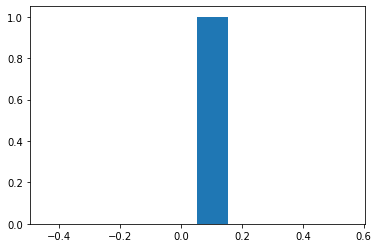

decoding on brain_area MOp
decoding on brain_area CP
session 29
decoding on brain_area CA1
decoding on brain_area PO
found!
max diff:  0.13970588235294124


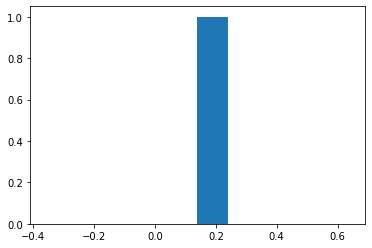

decoding on brain_area CL
decoding on brain_area LS
found!
max diff:  0.10523897058823528


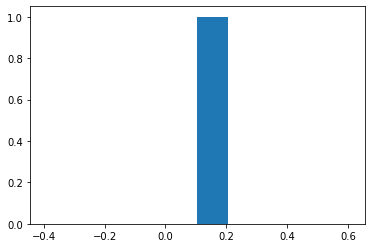

decoding on brain_area MOs
found!
max diff:  0.051930147058823484


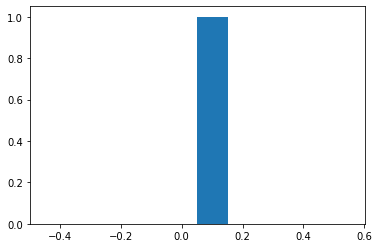

decoding on brain_area SUB
found!
max diff:  0.22977941176470584


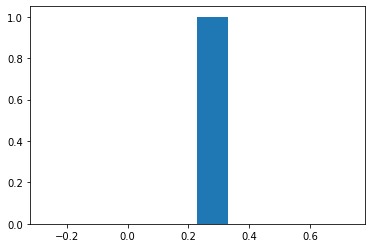

decoding on brain_area VPM
found!
max diff:  0.08915441176470584


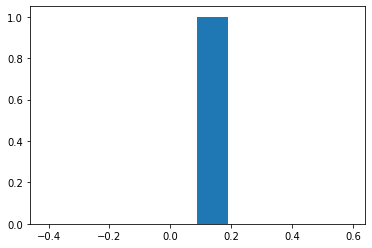

decoding on brain_area root
decoding on brain_area DG
decoding on brain_area ACA
decoding on brain_area MD
decoding on brain_area RSP
decoding on brain_area VISa
decoding on brain_area LP
session 30
decoding on brain_area OLF
decoding on brain_area MOs
decoding on brain_area SCm
decoding on brain_area ORB
decoding on brain_area TH
decoding on brain_area CA3
decoding on brain_area POST
decoding on brain_area SNr
session 31
decoding on brain_area OLF
decoding on brain_area MOs
decoding on brain_area ORB
decoding on brain_area SCm
decoding on brain_area PAG
decoding on brain_area root
decoding on brain_area MRN
decoding on brain_area RSP
decoding on brain_area SCs
session 32
decoding on brain_area CA1
decoding on brain_area CP
decoding on brain_area VPM
decoding on brain_area LGd
decoding on brain_area EP
decoding on brain_area root
decoding on brain_area CA3
decoding on brain_area ZI
decoding on brain_area SNr
session 33
decoding on brain_area PO
decoding on brain_area BMA
decoding on br

In [42]:
window = slice(0, 50, 1)
# window = slice(30, 50, 1)
thresh_print = 0.04
for i_session in range(n_sessions):
  print("session", i_session)
  filtered_data_focus = filtered_data[i_session]
  outcomes_correct = get_outcomes_correct_with_session(filtered_data_focus)
  brain_areas = set(filtered_data_focus['brain_area'])
  for brain_area in brain_areas:
    print("decoding on brain_area", brain_area)
    spikes_per_neuron = get_neurons_spikes_with_session_area_window(filtered_data_focus, brain_area, window) #  spikes_per_neuron.shape == (neurons*trials*time) 
    decoding_accuracies, decoding_accuracies_chance = compute_all_neuron_decoding_accuracies(spikes_per_neuron, outcomes_correct)
    decoding_accuracies_diff = decoding_accuracies - decoding_accuracies_chance
    if np.any(decoding_accuracies_diff > thresh_print):
      print("found!")
      # print("decoding_accuracies", decoding_accuracies)
      # print("decoding_accuracies_chance", decoding_accuracies_chance)
      print("max diff: ", (decoding_accuracies_diff).max())
      print("decoding_accuracies :",decoding_accuracies)
      plt.figure()
      #plt.hist(decoding_accuracies_diff)
      plt.show()

## Fitting the model manually

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """


  y_pred = model.predict(X)

  accuracy = np.count_nonzero(y_pred==y)/len(y)

  return accuracy

avg_spikes=spikes_focus.mean(axis=0)
print(avg_spikes.shape)
# outcomes_correct=>label 0 or 1
y = outcomes_correct
X = avg_spikes

# First define the model
log_reg = LogisticRegression(penalty="none")
#Then fit it to data
log_reg.fit(X, y)
y_pred = log_reg.predict(X)

train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data averaging over all neurons considering the whole time period: {train_accuracy:.2%}")

In [ ]:
X = avg_spikes[:, 0:50]
log_reg = LogisticRegression(penalty="none")
log_reg.fit(X, y)
y_pred = log_reg.predict(X)

train_accuracy = compute_accuracy(X, y, log_reg)

print(f"Accuracy on the training data averaging over all neurons considering the prestimulus period: {train_accuracy:.2%}")

In [ ]:
# X = spikes_focus[24, :, 0:50]
# log_reg = LogisticRegression(penalty="none")
# log_reg.fit(X, y)
# y_pred = log_reg.predict(X)

# train_accuracy = compute_accuracy(X, y, log_reg)

# print(f"Accuracy on the training data with a single neuron considering the prestimulus period: {train_accuracy:.2%}")

## Decode on average over the neurons and the prestimulus time zone

In [31]:
avg_neurones_prestimulus=spikes_focus[:,:,:50].mean(axis=2)
y = outcomes_correct
X = avg_neurones_prestimulus.T
scores = cross_val_score(LogisticRegression(penalty='l2'), X, y, cv=8) # k=8 crossvalidation
scores.mean()

NameError: ignored

In [ ]:
X_random=avg_neurones_prestimulus.T.copy()
np.random.shuffle(X_random)
chance_decoding_accuracy = cross_val_score(LogisticRegression(penalty='l2'),X_random, y, cv=8).mean() # k=8 crossvalidation
chance_decoding_accuracy

In [ ]:
print("X.shape", X.shape)

In [ ]:
# Iterate over single neurons
n_neurons = avg_neurones_prestimulus.shape[0]
mean_decoding_accuracies = np.empty(n_neurons)
for i_neuron in range(n_neurons):
  X = avg_neurones_prestimulus[i_neuron, :][:, None]
  mean_decoding_accuracies[i_neuron] = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8).mean()
plt.hist(mean_decoding_accuracies)
print(mean_decoding_accuracies)
print(mean_decoding_accuracies.max())

## Decode from all the neurons, over the prestimulus time zone

In [ ]:
#(275, 414, 250) =>(414,275*250)
X_all=[]

y = outcomes_correct

for i in range(len(spikes_focus[:,:,:50][0])):
  all_neuron_over_time_by_trial=[]
  for j in range(len(spikes_focus[:,:,:50])):
    
    for k in spikes_focus[:,:,:50][j][i]:
      all_neuron_over_time_by_trial.append(k)
  X_all.append(all_neuron_over_time_by_trial)

X_all=np.array(X_all)
X_all.shape

In [ ]:
cross_val_score(LogisticRegression(penalty='l2'), X_all, y, cv=8) # k=8 crossvalidation

# look for active neurons

In [ ]:
count=0
active_trial=np.zeros(len(spikes_focus))
for i in range(len(spikes_focus)):
  count=0
  for j in range(len(spikes_focus[0,:,0])):
    if spikes_focus[i,j,:].sum()<5:
      count+=1
  active_trial[i]=len(spikes_focus[0,:,0])-count
  #print(count,'/',j+1)
print(np.count_nonzero(active_trial>20))

In [ ]:
#@title Show some spikes data
_=plt.eventplot(spikes_focus[20:30,2,:])
spikes_focus[25:26,2,:]